In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import shap
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [ ]:
data = pd.read_csv('/content/Final_data.csv')

In [ ]:
data.head()

Unnamed: 0      id  funded_amount  loan_amount             activity  \
0           0  653051          300.0        300.0  Fruits & Vegetables   
1           1  653053          575.0        575.0             Rickshaw   
2           2  653068          150.0        150.0       Transportation   
3           3  653063          200.0        200.0           Embroidery   
4           4  653084          400.0        400.0           Milk Sales   

           sector country_code   country        region currency  partner_id  \
0            Food           PK  Pakistan        Lahore      PKR       247.0   
1  Transportation           PK  Pakistan        Lahore      PKR       247.0   
2  Transportation           IN     India     Maynaguri      INR       334.0   
3            Arts           PK  Pakistan        Lahore      PKR       247.0   
4            Food           PK  Pakistan  Abdul Hakeem      PKR       245.0   

                 posted_time             disbursed_time  \
0  2014-01-01 06:12:39+00:00  2013-12-17 08:00:00+00:00   
1  2014-01-01 06:51:08+00:00  2013-12-17 08:00:00+00:00   
2  2014-01-01 09:58:07+00:00  2013-12-17 08:00:00+00:00   
3  2014-01-01 08:03:11+00:00  2013-12-24 08:00:00+00:00   
4  2014-01-01 11:53:19+00:00  2013-12-17 08:00:00+00:00   

                 funded_time  term_in_months  lender_count borrower_genders  \
0  2014-01-02 10:06:32+00:00            12.0            12           female   
1  2014-01-02 09:17:23+00:00            11.0            14            group   
2  2014-01-01 16:01:36+00:00            43.0             6           female   
3  2014-01-01 13:00:00+00:00            11.0             8           female   
4  2014-01-01 19:18:51+00:00            14.0            16           female   

  repayment_interval        date  funding_days  
0          irregular  2014-01-01             1  
1          irregular  2014-01-01             1  
2             bullet  2014-01-01             0  
3          irregular  2014-01-01             0  
4            monthly  2014-01-01             0

In [ ]:

data.shape

(574127, 20)

In [ ]:
data.columns


Index(['Unnamed: 0', 'id', 'funded_amount', 'loan_amount', 'activity',
       'sector', 'country_code', 'country', 'region', 'currency', 'partner_id',
       'posted_time', 'disbursed_time', 'funded_time', 'term_in_months',
       'lender_count', 'borrower_genders', 'repayment_interval', 'date',
       'funding_days'],
      dtype='object')

In [ ]:
selected_features = ['sector','borrower_genders','loan_amount','term_in_months','country','lender_count']
df = data[selected_features]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574127 entries, 0 to 574126
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sector            574127 non-null  object 
 1   borrower_genders  574127 non-null  object 
 2   loan_amount       574127 non-null  float64
 3   term_in_months    574127 non-null  float64
 4   country           574127 non-null  object 
 5   lender_count      574127 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 26.3+ MB


In [ ]:
#small amount of rows missing genders. Could have imputed, but instead choose to just remove the tiny amount of rows that it was.

df = df.dropna(subset=['borrower_genders'])
#df = df.dropna(subset=['partner_id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574127 entries, 0 to 574126
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sector            574127 non-null  object 
 1   borrower_genders  574127 non-null  object 
 2   loan_amount       574127 non-null  float64
 3   term_in_months    574127 non-null  float64
 4   country           574127 non-null  object 
 5   lender_count      574127 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 26.3+ MB


In [ ]:
def gender_group(row):
    if row['borrower_genders'] == 'male':
        return 'male'
    elif row['borrower_genders'] == 'female':
        return 'female'
    else:
        return 'group'

# Apply the function and overwrite the 'borrower_genders' column
df['borrower_genders'] = df.apply(gender_group, axis=1)
df['borrower_genders'].value_counts()

borrower_genders
female    377749
male      103370
group      93008
Name: count, dtype: int64

In [ ]:
df['country'].value_counts()


country
Philippines      157532
Kenya             61839
Cambodia          33439
Pakistan          24917
Peru              21473
                  ...  
Benin                 2
Afghanistan           2
Mauritania            1
Cote D'Ivoire         1
Bhutan                1
Name: count, Length: 82, dtype: int64

In [ ]:
country_counts = df['country'].value_counts()
df = df[df['country'].isin(country_counts[country_counts >= 1000].index)]
df['country'].value_counts()

country
Philippines                             157532
Kenya                                    61839
Cambodia                                 33439
Pakistan                                 24917
Peru                                     21473
Uganda                                   18093
Tajikistan                               17443
Colombia                                 17262
El Salvador                              16505
Ecuador                                  12867
Paraguay                                 11518
India                                    10868
Nicaragua                                 9906
Vietnam                                   9877
Nigeria                                   9132
Bolivia                                   7511
Palestine                                 7097
Armenia                                   6804
Guatemala                                 6741
Samoa                                     6662
Lebanon                                   6384
Mali                                      6122
Honduras                                  5999
Togo                                      5612
Kyrgyzstan                                5158
Sierra Leone                              4937
Mexico                                    4793
Tanzania                                  4789
Indonesia                                 4523
Ghana                                     4152
Zimbabwe                                  3913
Jordan                                    3802
Haiti                                     3529
Liberia                                   3512
Madagascar                                3356
Mozambique                                3103
The Democratic Republic of the Congo      2940
Timor-Leste                               2446
Burkina Faso                              2402
Georgia                                   2232
Yemen                                     2146
Egypt                                     1600
Myanmar (Burma)                           1559
Cameroon                                  1529
Azerbaijan                                1498
Lao People's Democratic Republic          1483
Costa Rica                                1421
Albania                                   1414
Malawi                                    1263
Name: count, dtype: int64

In [ ]:
# Separate features and target
X = df.drop('loan_amount', axis=1)
y = df['loan_amount']

# One-hot encode categorical variables
ohe = OneHotEncoder() # be careful - output is a sparse matrix
cat_features = ['sector','borrower_genders','country']
X_cat = pd.DataFrame(ohe.fit_transform(X[cat_features]).todense(), columns=ohe.get_feature_names_out(cat_features))

# Scale numerical features
scaler = StandardScaler()
num_features = ['term_in_months','lender_count']
X_num = pd.DataFrame(scaler.fit_transform(X[num_features]), columns=num_features)

# Combine encoded categorical and scaled numerical features
X_processed = pd.concat([X_num, X_cat], axis=1)

print("Shape of processed features:", X_processed.shape)

Shape of processed features: (565103, 69)


In [ ]:
print("Unique values per categorical feature:")
for feature in cat_features:
    print(f"{feature}: {X[feature].nunique()}")

Unique values per categorical feature:
sector: 15
borrower_genders: 3
country: 49


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train XGBoost model
model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [ ]:
model_xgb.score(X_train, y_train)

0.8838204515618022

In [ ]:
model_xgb.score(X_test, y_test)

0.8059154261281543

In [ ]:
model_LinReg = LinearRegression()
model_LinReg.fit(X_train, y_train)


LinearRegression()

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [ ]:
model_LinReg.score(X_test, y_test)

0.798759563459952

In [ ]:
#Best model is xgboost, so we continue with this for tuning parameters.

scorer = make_scorer(mean_squared_error)

xgb_param_grid = {
   'n_estimators': [100, 200],
   'learning_rate': [0.01, 0.1],
   'max_depth': [3, 5],
   'subsample': [0.7, 0.8],
   'colsample_bytree': [0.7, 0.8]
}


grid_obj = GridSearchCV(model_xgb, xgb_param_grid, scoring=scorer)


grid_fit = grid_obj.fit(X_processed, y)

In [21]:
# Get the estimator.
best_reg = grid_fit.best_estimator_


In [22]:
# Fit the new model.
best_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
# Model performance on TEST data
best_reg.score(X_test, y_test)

0.4863470615940325

In [ ]:
#Conclusion on tuning: The parameters we tuned for did not improve the model, which is probably due to the limited options we gave the gridsearch. In a setting with more ressources
#and actual better computation power we could have perhaps tuned for more types of options. Instead we keep using the already existing model.


In [24]:
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train)))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, model_xgb.predict(X_test)))

print(f"Train RMSE XGBoost: {train_rmse_xgb:.2f}")
print(f"Test RMSE XGBoost: {test_rmse_xgb:.2f}")

Train RMSE XGBoost: 338.92
Test RMSE XGBoost: 450.41


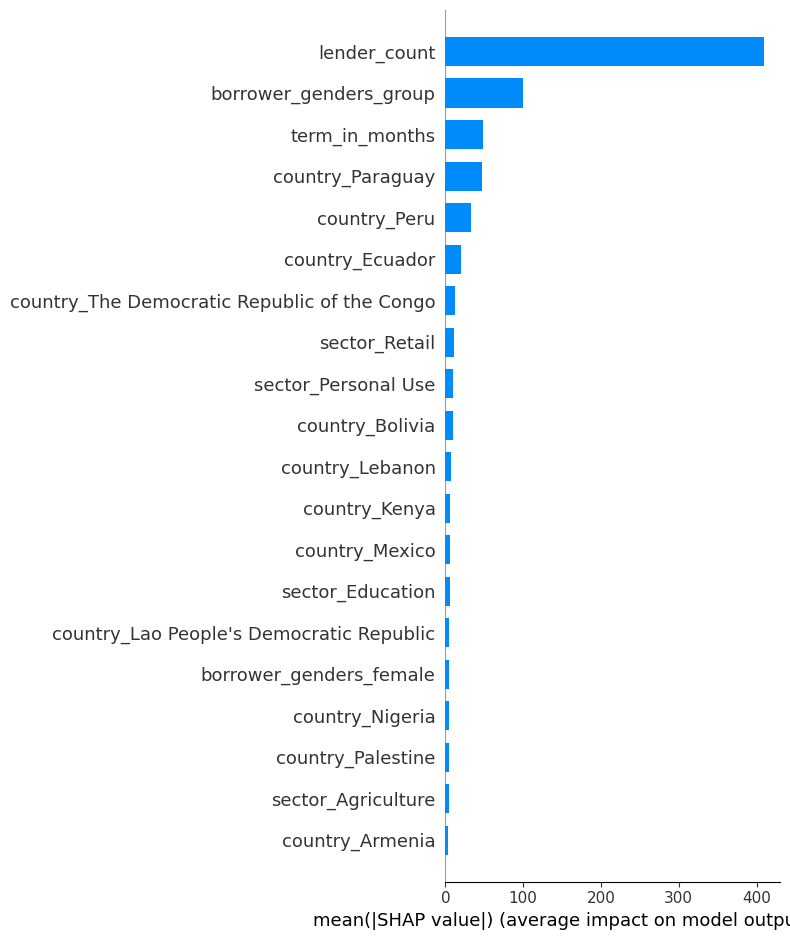

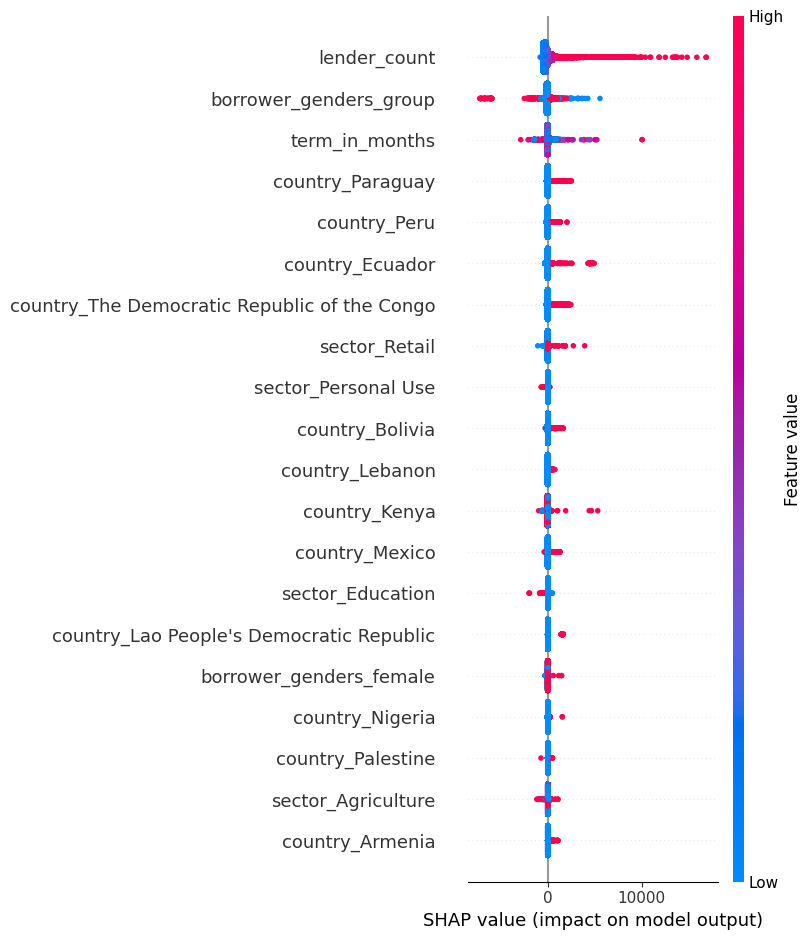

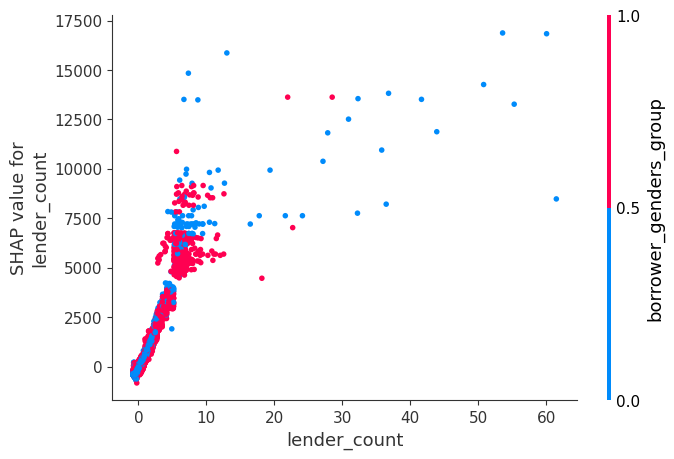

In [25]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

# Plot feature importances
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot SHAP values
shap.summary_plot(shap_values, X_test)

# Plot dependence for the most important feature
most_important_feature = X_test.columns[np.argmax(np.abs(shap_values).mean(0))]
shap.dependence_plot(most_important_feature, shap_values, X_test)

In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [27]:
joblib.dump(model_xgb, 'model_xgb.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(ohe, 'ohe.joblib')

['ohe.joblib']